In [30]:
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from os import path, system
from COG import COGTranslator, COGFunctions
from matplotlib import pyplot as plt

In [31]:
cogt = COGTranslator()
cogf = COGFunctions()

Loaded 4631 COG names into memory.


In [32]:
df = pd.read_csv("../data/metadata.csv")
df = df[df['is_synecho'] & df['quality_filter'] & (df['checkm_completeness'] > 85)]
cog_out_dir = "../data/ncbi/processing/synecho_cog/"
df['dmnd_out'] = df['proteins_path'].apply(lambda s: path.join(cog_out_dir,
                                                               path.basename(s).split("_genomic")[0] +
                                                               "_dmnd_out.tsv"))
df['cog_fasta'] = df['proteins_path'].apply(lambda s: path.join(cog_out_dir,
                                                               path.basename(s).split("_genomic")[0] +
                                                               "_cog_annotaton.faa"))
df['proteins_path'] = df['proteins_path'].str.replace("..//ncbi", "../data/ncbi")

In [33]:
cog_path = "/home/vini/data/db/COG/prot2003-2014.fa.dmnd"
cog_ids = pd.read_csv("/home/vini/data/db/COG/cog2003-2014.csv")
cog_ids = cog_ids.iloc[:, :-1]
cog_ids.columns = "domain_id genome_name protein_id protein_length\
                   domain_start domain_end COG_id membership_class".split()
cog_ids = cog_ids.drop_duplicates("domain_id")
cogt = COGTranslator()

def run_diamond(query, output, db=cog_path, outfmt=6, threads=8, max_target=0):
    command = f"diamond blastp -q {query} --db {db} -o {output} --outfmt {outfmt} -p {threads}"
    if max_target:
        command += f" -k {str(max_target)}"
    
    query_ = path.basename(query)
    print(f"Running Diamond for {query_} with {str(threads)} threads")
    if path.isfile(output):
        print(f"{output} already exists.|")
        return 0
    system(command)
    if path.isfile(output):
        print(f"Success. Finished diamond for {query}.\nOutput file is {output}")
        return 0
    else:
        return "Failed. Did not create output file."


def parse_seqid(seqid, kind='name'):
    seqid = int(seqid.split("|")[1])
    query = cog_ids.query(f"domain_id == {seqid}")
    if len(query) >= 1:
        cog_code = cog_ids.query(f"domain_id == {seqid}").iloc[0]['COG_id']
        name = cogt.name_from_code(cog_code)
        letter = cogt.letter_from_code(cog_code)
        output = {
            'name': name,
            'code': cog_code,
            'category': letter
        }
        return output[kind]
    else:
        return 0


def description_parser(description, code, category, annotation):
    split = description.split(" # ")
    id_ = split[0]
    gc_cont = split[-1].split(";")[-1]
    category = "".join([i[0] for i in category])
    output = " # ".join([id_, code, category, annotation, gc_cont])
    return output


def process_row(row):
    # Process Diamond output
    dmnd = pd.read_csv(row['dmnd_out'], sep="\t")
    dmnd.columns = 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore'.split()
    dmnd.set_index("qseqid", inplace=True)
    dmnd['annotation'] = dmnd['sseqid'].apply(lambda s: parse_seqid(s))
    dmnd['code'] = dmnd['sseqid'].apply(lambda s: parse_seqid(s, kind='code'))
    dmnd['category'] = dmnd['sseqid'].apply(lambda s: parse_seqid(s, kind='category'))
    
    fasta = SeqIO.to_dict(SeqIO.parse(row['proteins_path'], 'fasta'))
    for ix, row_ in dmnd.iterrows():
        description = fasta[ix].description
        code = row_['code']
        category = row_['category']
        annotation = row_['annotation']
        if code != 0:
            fasta[ix].description = description_parser(description, code, category, annotation)
      
    with open(row['cog_fasta'], 'w') as f:
        SeqIO.write([i for i in fasta.values()], f, 'fasta')
        
    # print(f"Finished for {row['sample-id']}.")

Loaded 4631 COG names into memory.


In [34]:
# df.apply(lambda row: run_diamond(query=row['proteins_path'], db=cog_path, output=row['dmnd_out'], max_target=1) if not
#         path.isfile(row['dmnd_out']) else 0, axis=1)

In [35]:
# df.apply(lambda row: process_row(row) if not
#          path.isfile(row['cog_fasta']) else
#          f"Done for {row['cog_fasta']}", axis=1)

In [36]:
def get_cog_codes(cog_fasta):
    records = SeqIO.parse(cog_fasta, "fasta")
    cog_codes = dict()
    for seq in records:
        description = seq.description.split(" # ")
        cog_code = description[1]
        if not cog_code.startswith("COG"):
            pass
        else:
            if cog_code not in cog_codes.keys():
                cog_codes[cog_code] = 1
            cog_codes[cog_code] += 1
    
    return cog_codes
            

def get_cog_letters(cog_fasta):
    records = SeqIO.parse(cog_fasta, "fasta")
    cog_letters_dict = dict()
    for seq in records:
        description = seq.description.split(" # ")
        cog_code = description[1]
        if not cog_code.startswith("COG"):
            pass
        else:
            cog_letters = list(description[2])
            for letter in cog_letters:
                letter = cogf.cat_from_letter(letter)[0][1][1]
                if letter not in cog_letters_dict.keys():
                    cog_letters_dict[letter] = 1
                cog_letters_dict[letter] += 1

    return cog_letters_dict

In [37]:
cog_series = []
df.apply(lambda row: cog_series.append(
    pd.Series(
        get_cog_letters(row['cog_fasta']),
        name=row['assembly_accession']
        )
    ), axis=1
)

1       None
2       None
5       None
6       None
7       None
        ... 
1073    None
1074    None
1075    None
1077    None
1078    None
Length: 137, dtype: object

In [38]:
old_df = df

# Concatenate all dataframes
cog_df = pd.concat(cog_series, axis=1).T

# Merge on index
df_ = old_df.set_index("assembly_accession")
cog_df = df_.merge(cog_df, left_index=True, right_index=True)

# Filter singletons
cog_df['no_genus'] = cog_df.groupby('new_genus')['new_genus'].transform('count').map(int, na_action="ignore")

# Group by genera
groupby = cog_df[
    cog_df['no_genus'] > 1][list(cog_df.columns[65:]) + ["new_genus"]].groupby("new_genus").mean()

# Further formatting
groupby = round(groupby.dropna(axis=1), 3)
groupby = groupby[[i for i in groupby.columns if i not in ("General function prediction only",
                                                           "Function unknown")]]

# Export
output = "../data/cog/cog_groupby_85_completeness.csv"
groupby.to_csv(output)

In [39]:
# Don't group by genera
df = cog_df[(cog_df['no_genus'] > 1) & (cog_df['checkm_completeness'] > 95) & (cog_df['label'].apply(lambda s: s[1] != "_"))][list(cog_df.columns[65:]) + ["new_genus", "label"]]
df = df.dropna(axis=1)
df = df[[i for i in df.columns if i not in ("General function prediction only",
                                                           "Function unknown")]]
# Export
output = "../data/cog/cog_95_completeness.csv"
df.to_csv(output, index=False)

In [40]:
df = pd.read_csv(output)
df = df.sort_values("no_genus", ascending=False)

families = {
    "Parasynechococcus": "Cyanobiaceae",
    "Pseudosynechococcus": "Cyanobiaceae",
    "Synechospongium": "Cyanobiaceae",
    "Vulcanococcus": "Cyanobiaceae",
    "Lacustricoccus": "Cyanobiaceae",
    "Regnicoccus": "Cyanobiaceae",
    "Inmanicoccus": "Cyanobiaceae",
    "Cyanobium": "Cyanobiaceae",
    "Synechococcus": "Synechococcaceae",
    "Thermosynechococcus": "Thermosynechoccaceae",
    "Limnothrix": "Limnotrichaceae",
    "Leptococcus": "Leptococcaceae"
}

family_color = {
    "Cyanobiaceae": "tab:blue",
    "Synechococcaceae": "tab:green",
    "Thermosynechoccaceae": "tab:purple",
    "Limnotrichaceae": "tab:cyan",
    "Leptococcaceae": "tab:purple"
}

ecotypes = {
    "Parasynechococcus": "Marine",
    "Pseudosynechococcus": "Marine",
    "Synechospongium": "Marine",
    "Vulcanococcus": "Halotolerant",
    "Lacustricoccus": "Freshwater",
    "Regnicoccus": "Halotolerant",
    "Inmanicoccus": "Marine",
    "Cyanobium": "Halotolerant",
    "Synechococcus": "Freshwater",
    "Thermosynechococcus": "Thermophilic",
    "Limnothrix": "Halotolerant",
    "Leptococcus": "Thermophilic"
}

ecotype_color = {
    "Marine": "#000080",
    "Freshwater": "#009000",
    "Thermophilic": "#900090",
    "Halotolerant": "#707030"
}


df['Family'] = df['new_genus'].apply(lambda s: families[s])
df['Ecotype'] = df['new_genus'].map(ecotypes)
df['f_color'] = df['Family'].map(family_color)
df['e_color'] = df['Ecotype'].map(ecotype_color)

## Plotting

In [41]:
def plot_heatmap(df, figsize=(20, 15), save=False, show=True, **kwargs):
    
    df = df.set_index("no_genus")
    # Grid
    gridkw = dict(width_ratios=[30, 1], wspace=0.03)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=figsize, sharey=True)
    
    sns.heatmap(df.iloc[:, :-2], cmap='YlGnBu', cbar=False, ax=ax1, annot=df.iloc[:, :-2], fmt='.1f', **kwargs)
    ax1.tick_params(axis='x', rotation=90)
    
    if show:
        plt.show()

In [46]:
def plot_clustermap(df, figsize=(10, 10), groupby=False, save=False, row_color="Family", **kwargs):
    
    if groupby:
        df = round(df.groupby("new_genus").mean(), 3)
        df.index.name = "Genus"
        df["new_genus"] = df.index
        df['Family'] = df['new_genus'].apply(lambda s: families[s])
        df['Ecotype'] = df['new_genus'].map(ecotypes)
        df['f_color'] = df['Family'].map(family_color)
        df['e_color'] = df['Ecotype'].map(ecotype_color)
    else:
        df = df.set_index("label")
        df.index.name = "Genome"
        
    if row_color == "Family":
        row_colors = df['Family'].map(family_color)
    
    elif row_color == "Ecotype":
        row_colors = df['Ecotype'].map(ecotype_color)
    
    sns.clustermap(df.iloc[:, :20], row_colors=row_colors, figsize=figsize, **kwargs)
    
    if save:
        plt.savefig(save, dpi=1200)

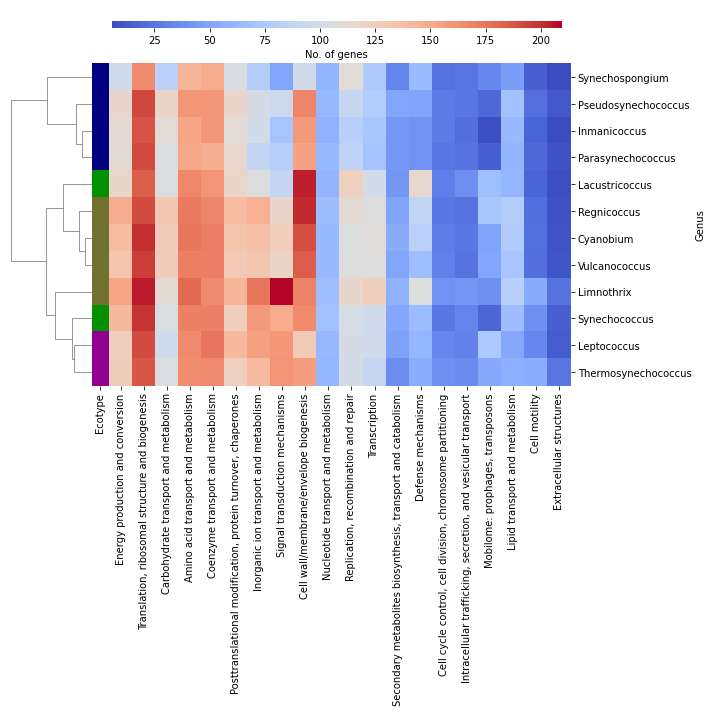

In [69]:
plot_clustermap(df, cmap='coolwarm', groupby=True,
                col_cluster=False, metric='braycurtis', method='complete',
                cbar_kws={'orientation': 'horizontal', 'label': "No. of genes"}, cbar_pos=(.16, 0.955, .625, 0.01),
                row_color="Ecotype", figsize=(10, 10), dendrogram_ratio=.15,
                save="../data/plots/final/Figure_4_COG.pdf")
                #)

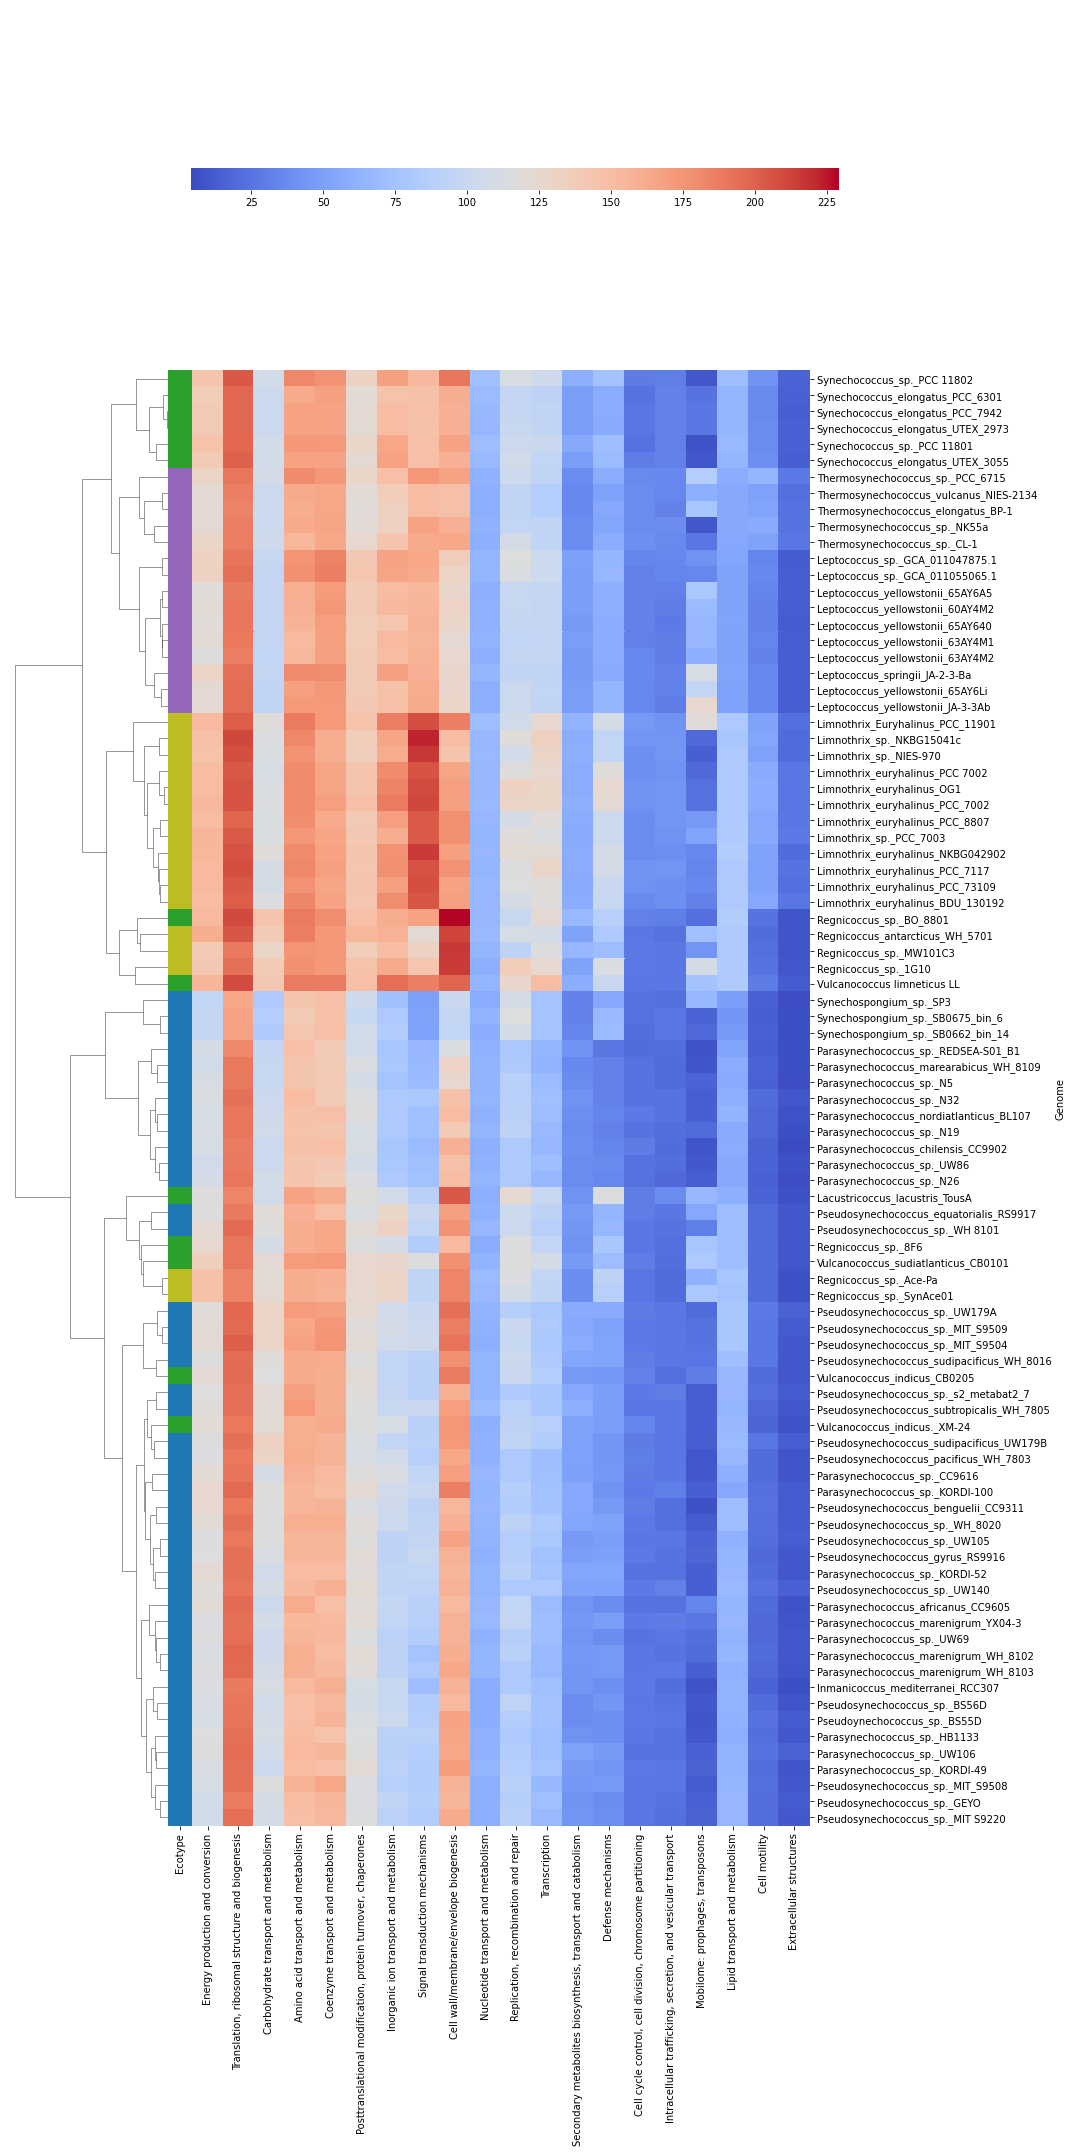

In [617]:
plot_clustermap(df, cmap='coolwarm', groupby=False,
                col_cluster=False, metric='braycurtis', method='complete',
                cbar_kws={'orientation': 'horizontal'}, cbar_pos=(.18, 0.91, .6, 0.01),
                row_color="Ecotype", figsize=(15, 30)
                )